<a href="https://colab.research.google.com/github/marianamelodev/telecom-x-parte-2/blob/main/Telecom_X_Parte_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# 1. Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from google.colab import files

In [20]:
# 2. Upload do arquivo CSV limpo
print("Faça upload do seu arquivo CSV limpo da Parte 1")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print(f"Arquivo '{filename}' carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

Faça upload do seu arquivo CSV limpo da Parte 1


Saving df_limpo.csv to df_limpo (1).csv
Arquivo 'df_limpo (1).csv' carregado com 7043 linhas e 22 colunas.


In [21]:
# 3. Informações gerais da base
print("\nInfo do dataset:")
print(df.info())
print("\nDistribuição da variável alvo (Churn):")
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True))


Info do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   int64  
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   int64  
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       704

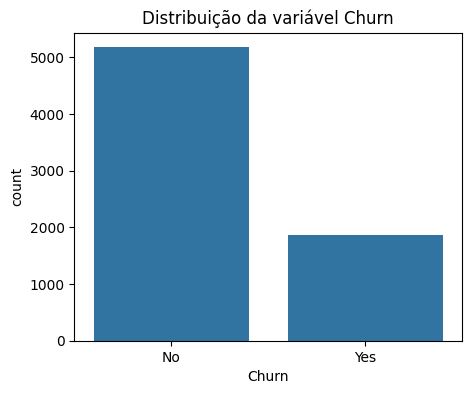

In [22]:
# 4. Visualização básica da variável alvo
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df)
plt.title("Distribuição da variável Churn")
plt.show()

In [23]:
# 5. Separar variáveis categóricas e numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nColunas numéricas: {numeric_cols}")
print(f"Colunas categóricas: {categorical_cols}")


Colunas numéricas: ['customer.SeniorCitizen', 'customer.tenure', 'Total.Day', 'account.Charges.Monthly', 'account.Charges.Total']
Colunas categóricas: ['customerID', 'Churn', 'customer.gender', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod']


In [24]:
# Remover ID se existir
for id_col in ['customerID', 'CustomerID', 'id', 'ID']:
    if id_col in df.columns:
        df.drop(columns=id_col, inplace=True)
        print(f"Coluna '{id_col}' removida.")

Coluna 'customerID' removida.


In [25]:
# 6. One-hot encoding para variáveis categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

In [26]:
# 7. Separar X e y
target_col = 'Churn_Yes' if 'Churn_Yes' in df_encoded.columns else 'Churn'
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

In [27]:
# 8. Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [28]:
# 9. Balanceamento com SMOTE no treino

# Impute missing values using the mean of the training set
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print(f"\nAntes SMOTE: {y_train.value_counts()}")
print(f"Depois SMOTE: {y_train_sm.value_counts()}")


Antes SMOTE: Churn_Yes
False    3622
True     1308
Name: count, dtype: int64
Depois SMOTE: Churn_Yes
False    3622
True     3622
Name: count, dtype: int64


In [29]:
# 10. Normalizar dados para modelos que precisam (ex: Logistic Regression)
scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

In [30]:
# 11. Treinar Regressão Logística
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_sm_scaled, y_train_sm)
y_pred_log = logreg.predict(X_test_scaled)
y_proba_log = logreg.predict_proba(X_test_scaled)[:,1]

In [31]:
# 12. Treinar Random Forest (não precisa de normalização)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

In [32]:
# 13. Avaliar modelos
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("\n=== Regressão Logística ===")
print(classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_proba_log))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_log))

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_rf))


=== Regressão Logística ===
              precision    recall  f1-score   support

       False       0.91      0.72      0.81      1552
        True       0.51      0.80      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.74      0.76      2113

ROC AUC: 0.8403221879192164
Matriz de confusão:
 [[1125  427]
 [ 112  449]]

=== Random Forest ===
              precision    recall  f1-score   support

       False       0.84      0.88      0.86      1552
        True       0.61      0.53      0.56       561

    accuracy                           0.78      2113
   macro avg       0.72      0.70      0.71      2113
weighted avg       0.78      0.78      0.78      2113

ROC AUC: 0.8227616140176782
Matriz de confusão:
 [[1361  191]
 [ 266  295]]


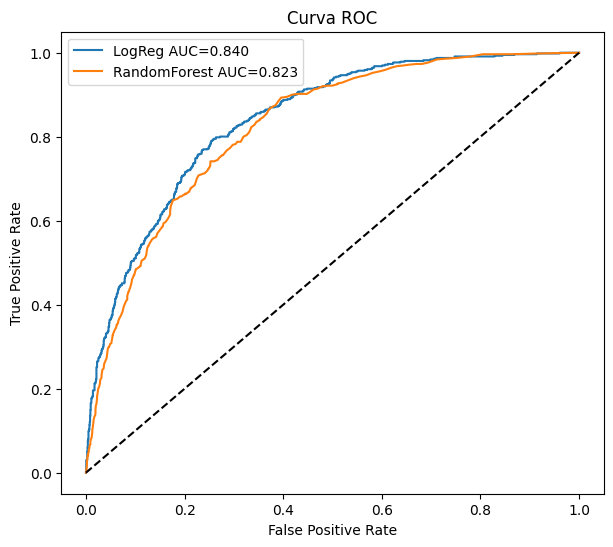

In [33]:
# 14. Plotar curva ROC
plt.figure(figsize=(7,6))
fpr, tpr, _ = roc_curve(y_test, y_proba_log)
plt.plot(fpr, tpr, label=f'LogReg AUC={roc_auc_score(y_test,y_proba_log):.3f}')
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label=f'RandomForest AUC={roc_auc_score(y_test,y_proba_rf):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

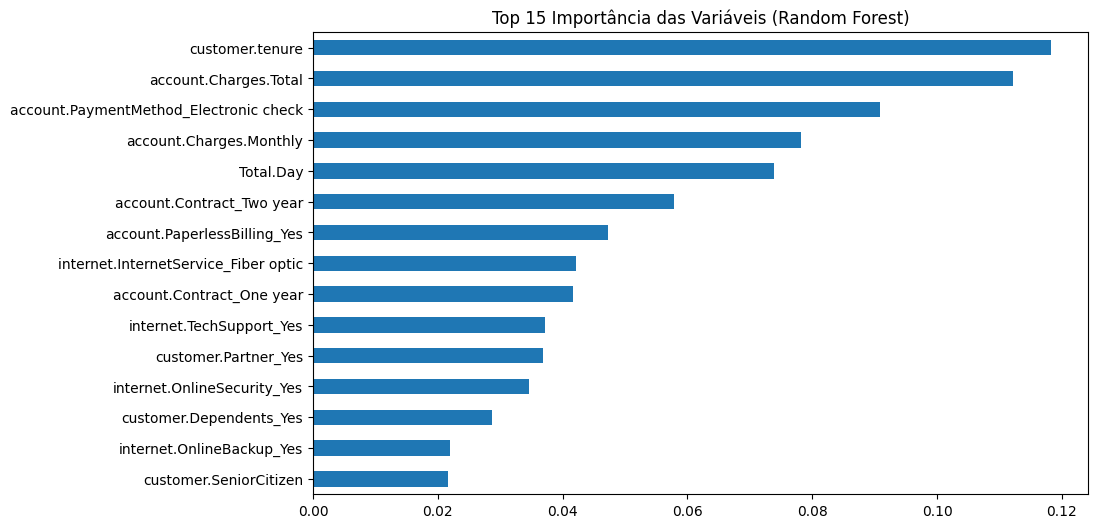

In [34]:
# 15. Importância das variáveis (Random Forest)
features = X.columns
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(10,6))
feat_imp.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Importância das Variáveis (Random Forest)')
plt.show()

##📋 Resumo e Considerações Finais
Neste notebook, realizamos todo o processo de modelagem preditiva para o desafio Telecom X – Parte 2, seguindo as etapas essenciais de Machine Learning:

- Carregamento e inspeção dos dados — importei o arquivo CSV limpo da Parte 1 e entendi sua estrutura, tipos e distribuição da variável alvo (Churn).

- Pré-processamento — removi colunas irrelevantes (como IDs), apliquei codificação One-Hot nas variáveis categóricas para transformar os dados em formato numérico adequado para os modelos.

- Divisão dos dados — separei os dados em conjuntos de treino e teste, preservando a proporção original da variável alvo (estratificação).

- Balanceamento da base — apliquei o SMOTE para corrigir o desbalanceamento da variável alvo no conjunto de treino, gerando amostras sintéticas da classe minoritária.

- Normalização — para o modelo de Regressão Logística, normalizei as variáveis numéricas, etapa fundamental para algoritmos baseados em distância.

- Treinamento de modelos — criei e treinamos dois modelos: Regressão Logística (com dados normalizados) e Random Forest (modelo baseado em árvore que não precisa de normalização).

- Avaliação dos modelos — usei métricas de classificação (precisão, recall, F1-score), matriz de confusão e a curva ROC/AUC para comparar o desempenho dos modelos na previsão de evasão (churn).

- Interpretação dos resultados — visualizei a importância das variáveis para o modelo Random Forest, destacando os principais fatores que influenciam a evasão dos clientes.